In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **데이터 준비**

In [4]:
import numpy as np
import pandas as pd

# 최대 행렬 수를 설정합니다.
pd.set_option('display.max_column', 50)
pd.set_option('display.max_rows', 50)

# 데이터를 읽습니다.
data_path = '/kaggle/input/titanic/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'gender_submission.csv')

데이터 사이즈가 크지 않으므로 난수에 따라 결과가 달라지기 쉽습니다. 랜덤 시드를 설정하겠습니다. 

In [5]:
import random
np.random.seed(2022)
random.seed(2022)

# **데이터 확인**

## **데이터 개요**

데이터를 살펴보겠습니다.

In [6]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [8]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


'Survived' 피처를 예측하는 문제이므로 테스트 세트에는 'Survived' 피처가 없습니다.

## **피처 개요**

피처를 요약하는 함수를 선언하여 데이터 크기, 피처 타입, 결측치 개수, 고윳값 개수를 출력해 보겠습니다.

In [11]:
def feature_table(df):
    # 피처 이름과 타입을 출력합니다.     
    feature_description = pd.DataFrame(df.dtypes, columns=['type'])
    feature_description = feature_description.reset_index()
    feature_description = feature_description.rename(columns={'index': 'feature'})
    # 결측치 개수를 산출합니다.
    feature_description['null count'] = df.isnull().sum().values
    # 고윳값 개수를 산출합니다.
    feature_description['eigenvalue count'] = df.nunique().values
    
    # 데이터 크기를 출력합니다.    
    print(df.shape)
    
    return feature_description

In [12]:
feature_table(train)

(891, 12)


,feature,type,null count,eigenvalue count
0,PassengerId,int64,0,891
1,Survived,int64,0,2
2,Pclass,int64,0,3
3,Name,object,0,891
4,Sex,object,0,2
5,Age,float64,177,88
6,SibSp,int64,0,7
7,Parch,int64,0,7
8,Ticket,object,0,681
9,Fare,float64,0,248


In [13]:
feature_table(test)

(418, 11)


,feature,type,null count,eigenvalue count
0,PassengerId,int64,0,418
1,Pclass,int64,0,3
2,Name,object,0,418
3,Sex,object,0,2
4,Age,float64,86,79
5,SibSp,int64,0,7
6,Parch,int64,0,8
7,Ticket,object,0,363
8,Fare,float64,1,169
9,Cabin,object,327,76


결측치가 존재하는 피처는 3개입니다. 다른 값으로 대체할지 피처 자체를 제거할지 고민할 필요가 있습니다. 특히 'Cabin' 피처의 경우 결측치가 너무 많습니다.

몇몇 피처와 'Survieved' 피처의 관계를 확인해 보겠습니다. 'PassengerId', 'Name', 'Ticket' 피처는 데이터 분석에 큰 영향이 없을 것으로 일단 추정하고 관계 파악 범주에서 제외하겠습니다. 먼저 'Survived' 피처의 비율을 확인해 보겠습니다.

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mpl.rc('font', size=20)
plt.style.use('ggplot')

0    549
1    342
Name: Survived, dtype: int64


<AxesSubplot:xlabel='Survived', ylabel='count'>

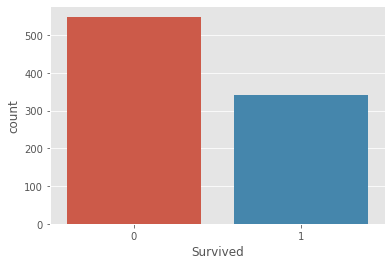

In [15]:
print(train['Survived'].value_counts())
sns.countplot(x='Survived', data=train)

사망자 수가 더 많습니다.

'Pclass', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [16]:
train[['Pclass', 'Survived', 'PassengerId']].groupby(['Pclass', 'Survived']).count()

PassengerId
Pclass Survived             
1      0                  80
       1                 136
2      0                  97
       1                  87
3      0                 372
       1                 119

<AxesSubplot:xlabel='Pclass', ylabel='count'>

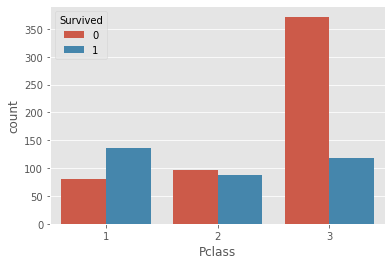

In [17]:
sns.countplot(x='Pclass', hue='Survived', data=train)

'1'은 생존자 수가 더 많고, '2'는 큰 차이가 없으며, '3'은 사망자 수가 더 많습니다. 티켓 등급이 낮을수록 사망자 수가 더 많은 것으로 추정합니다.

'Sex', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [18]:
train[['Sex', 'Survived', 'PassengerId']].groupby(['Sex', 'Survived']).count()

PassengerId
Sex    Survived             
female 0                  81
       1                 233
male   0                 468
       1                 109

<AxesSubplot:xlabel='Sex', ylabel='count'>

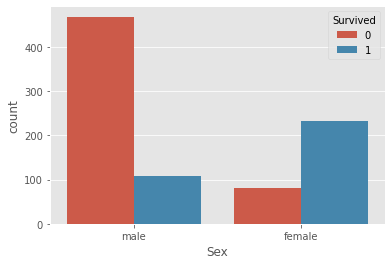

In [19]:
sns.countplot(x='Sex', hue='Survived', data=train)

남성 사망자 수가 월등히 많습니다.

'Age', 'Survived' 피처의 관계를 확인해 보겠습니다.

<AxesSubplot:xlabel='Age', ylabel='Count'>

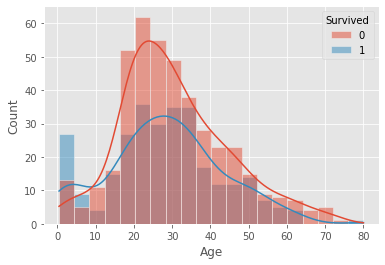

In [20]:
sns.histplot(x="Age", hue='Survived', data=train, kde=True)

10세 이하인 탑승객의 생존율이 높습니다. 나머지 연령대는 사망자 수가 더 많습니다.

'SibSp', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [21]:
train[['SibSp', 'Survived', 'PassengerId']].groupby(['SibSp', 'Survived']).count()

PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7

<AxesSubplot:xlabel='SibSp', ylabel='count'>

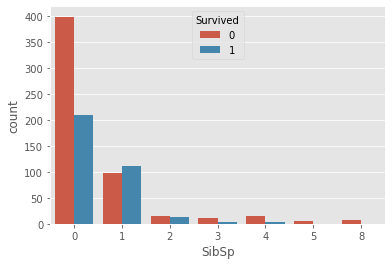

In [22]:
sns.countplot(x='SibSp', hue='Survived', data=train)

함께 승선한 형제나 배우자 수가 '0'이면 사망자 수가 많습니다. 다만 '1'을 제외하면 형제나 배우자 수가 많아지더라도 사망자 수가 오히려 높은 경향도 보입니다.

'Parch', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [23]:
train[['Parch', 'Survived', 'PassengerId']].groupby(['Parch', 'Survived']).count()

PassengerId
Parch Survived             
0     0                 445
      1                 233
1     0                  53
      1                  65
2     0                  40
      1                  40
3     0                   2
      1                   3
4     0                   4
5     0                   4
      1                   1
6     0                   1

<AxesSubplot:xlabel='Parch', ylabel='count'>

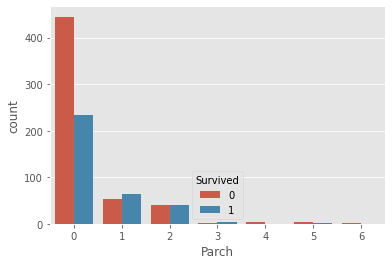

In [24]:
sns.countplot(x='Parch', hue='Survived', data=train)

함께 승선한 부모나 자녀의 수가 '0'이면 사망자 수가 높습니다. 다만 부모나 자녀의 수가 많아질수록 오히려 사망자 수가 높은 경우도 존재합니다.

'Embarked', 'Survived' 피처의 관계를 확인해 보겠습니다.

In [25]:
train[['Embarked', 'Survived', 'PassengerId']].groupby(['Embarked', 'Survived']).count()

PassengerId
Embarked Survived             
C        0                  75
         1                  93
Q        0                  47
         1                  30
S        0                 427
         1                 217

<AxesSubplot:xlabel='Embarked', ylabel='count'>

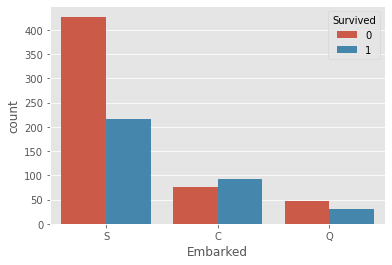

In [26]:
sns.countplot(x='Embarked', hue='Survived', data=train)

'S'의 경우 사망자 수가 월등히 높지만 다른 클래스는 사망과 생존의 비율이 약간 차이 나는 정도입니다.

각 피처별 통계량을 확인해 보겠습니다.

In [27]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


몇 피처와 'Survived' 피처 간 상관계수를 확인해 보겠습니다. 먼저 상관관계를 파악하려면 숫자가 아닌 피처를 수치화해야 합니다. 'Sex', 'Embarked' 피처를 수치화하기 위해 원-핫 인코딩을 적용하겠습니다.

In [28]:
train_correlation_df = pd.get_dummies(train, columns=['Sex']) # 클래스가 2개이므로 `drop_first=True`를 지정하여 중복된 열을 제외해도 좋습니다.
train_correlation_df = pd.get_dummies(train_correlation_df, columns=['Embarked'])
train_correlation_df.head(3)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1


In [29]:
train_correlation = train_correlation_df.corr()
train_correlation

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,0.042939,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.243292,0.221009,0.081720
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.093254,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.245489,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,-0.182333,0.269335,-0.117216,-0.166603
Sex_female,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,-1.000000,0.082853,0.074115,-0.125722
Sex_male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.082853,-0.074115,0.125722
Embarked_C,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,-0.082853,1.000000,-0.148258,-0.778359


<AxesSubplot:>

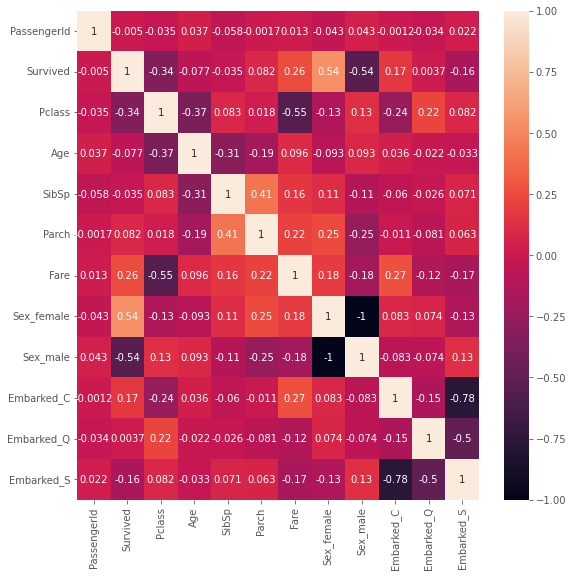

In [30]:
plt.figure(figsize=(9, 9))
sns.heatmap(train_correlation, annot=True)

상관관계가 가장 강한 피처는 'Sex'입니다. 여성이 남성보다 생존률이 높으므로 양수를 나타냅니다. 다음으로 상관관계가 강한 피처는 'Pclass'입니다. 티켓 등급이 높을수록 생존율이 높고 낮을수록 생존율도 낮습니다. 'Fare' 피처 또한 생존율에 영향을 주는 것으로 판단할 수 있습니다. 다만 'Age' 피처와의 상관관계가 매우 약한 것으로 나타납니다. 10세 이하의 생존율이 높은 점을 확인했으므로 이 지표만으로 상관관계가 약하다고 보는 것은 속단입니다. 일단 파악만 하고 넘어가겠습니다.

마지막으로 'Cabin' 피처의 고윳값을 확인해 보겠습니다.

In [31]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [32]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

사용할 수 없는 피처로 판단합니다. 피처 엔지니어링 때 피처 자체를 제거해야 옳습니다.

# **추가 분석**

티켓 등급별 티켓 요금 분포를 확인해 보겠습니다. 더 정확하게 분석하려면 `train` 데이터 세트와 `test` 데이터 세트를 결합하는 것이 좋지만 일단 그대로 진행해 보겠습니다.

In [40]:
train[['Pclass', 'Fare']].groupby('Pclass').describe()

Fare                                                              
        count       mean        std  min       25%      50%   75%       max
Pclass                                                                     
1       216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292
2       184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000
3       491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

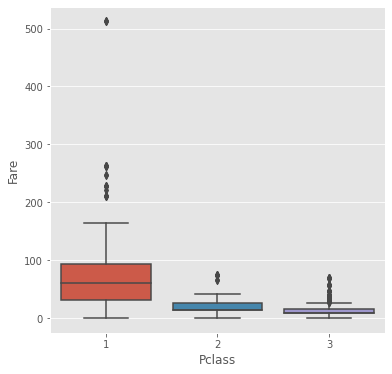

In [50]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Pclass', y='Fare', data=train)

티켓 등급이 높을수록 티켓 요금이 매우 높습니다. 상위 25% 이상인 고가의 티켓을 대상으로 새 피처를 생성하고 7(등급)을 부여하겠습니다.

In [42]:
# 새 피처를 생성합니다.
train['Gold_Pclass'] = train['Pclass']

# 새 피처에 7로 채웁니다.
train.loc[train['Fare'] > 93.5, 'Gold_Pclass'] = 7

티켓이 7등급인 승객을 확인해 보겠습니다.

In [43]:
train[train['Gold_Pclass']==7]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gold_Pclass
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,7
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,7
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,7
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,7
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,7
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S,7
779,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,7
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S,7


티켓 등급에 따라 어떤 연령대가 분포하는지 확인해 보겠습니다.

In [44]:
train[['Gold_Pclass', 'Age']].groupby('Gold_Pclass').describe()

Age                                                      
             count       mean        std   min    25%   50%    75%   max
Gold_Pclass                                                             
1            138.0  40.416667  14.305910  4.00  30.00  39.0  50.75  80.0
2            173.0  29.877630  14.001077  0.67  23.00  29.0  36.00  70.0
3            355.0  25.140620  12.495398  0.42  18.00  24.0  32.00  74.0
7             48.0  31.956667  14.550628  0.92  21.75  33.0  40.25  64.0

In [55]:
train[train['Age'] > 10][['Gold_Pclass', 'Age']].groupby('Gold_Pclass').describe()

Age                                                      
             count       mean        std   min    25%   50%    75%   max
Gold_Pclass                                                             
1            137.0  40.682482  14.012190  16.0  30.00  39.0  51.00  80.0
2            156.0  32.753205  11.497054  13.0  24.00  30.0  39.00  70.0
3            311.0  28.032154  10.452840  11.0  20.00  26.0  33.00  74.0
7             46.0  33.282609  13.341103  11.0  22.25  35.0  40.75  64.0

<AxesSubplot:xlabel='Gold_Pclass', ylabel='Age'>

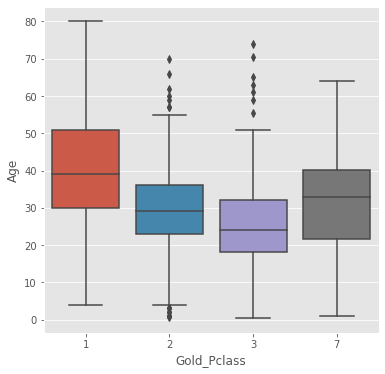

In [51]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Gold_Pclass', y='Age', data=train)

나이가 많을수록 티켓 등급이 높아집니다. 최상 등급인 7등급 또한 2등급과 3등급보다 연령대가 높은 편입니다.

연령대와 티켓 등급의 분포를 확인해 보겠습니다.

<AxesSubplot:xlabel='Age', ylabel='Fare'>

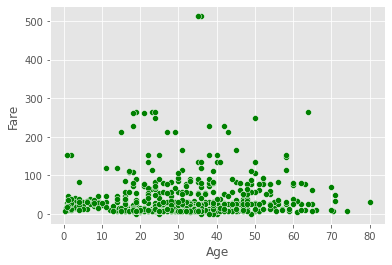

In [59]:
sns.scatterplot(x='Age', y='Fare', data=train, color='green')

티켓 등급은 다양한 연령대에 분포되어 있습니다.

티켓 등급별 함께 승선한 사람수에 대한 분포를 확인해 보겠습니다.

In [60]:
# 두 피처 값을 합하면 함께 탑승한 총 인원이 됩니다.
train['All_sum'] = train['SibSp'] + train['Parch']
train[['Gold_Pclass', 'All_sum']].groupby('Gold_Pclass').describe()

All_sum                                               
              count      mean       std  min  25%  50%   75%   max
Gold_Pclass                                                       
1             163.0  0.521472  0.660503  0.0  0.0  0.0  1.00   2.0
2             184.0  0.782609  1.054017  0.0  0.0  0.0  1.25   5.0
3             491.0  1.008147  1.953525  0.0  0.0  0.0  1.00  10.0
7              53.0  1.547170  1.513605  0.0  0.0  1.0  2.00   5.0

<AxesSubplot:xlabel='Gold_Pclass', ylabel='All_sum'>

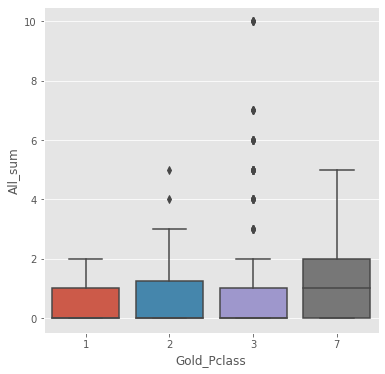

In [66]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Gold_Pclass', y='All_sum', data=train)

7등급 티켓의 경우 함께 탑승한 인원의 평균이 1 이상인 약 1.5이므로 함께 탑승한 비율이 높다고 판단할 수 있습니다. 1등급 티켓의 경우 함께 탑승한 인원의 평균이 약 0.5로 가장 낮습니다. 3등급 티켓의 경우 이상치로써 많은 탑승객이 함께 탄 것으로 확인됩니다.

---

추가 분석 시도 중

---